In [6]:
import pandas as pd ## Обновить pandas до последней версии
import numpy as np
import math
import os
import glob
import mysql.connector
import datetime
from mysql.connector import errorcode
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
from datetime import date
import string
from IPython.display import display, HTML
import os.path

import matplotlib as matplotlib
from decimal import Decimal
import math
import statistics

from os import listdir
from os.path import isfile, join

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

In [7]:
my_path = input("Введите путь папки, в которой будут лежать все ваши файлы (пример формата C:\\Users\\User\\Documents\\Python Scripts\\IT\\Untitled Folder): ")
while my_path  == '':
    print("Ошибка: вы не ввели путь папки")
    my_path = input("Введите путь папки, в которой будут лежать все ваши файлы (пример формата C:\\Users\\User\\Documents\\Python Scripts\\IT\\Untitled Folder): ")
print("Вы ввели '" + str(my_path)+"'")

Введите путь папки, в которой будут лежать все ваши файлы (пример формата C:\Users\User\Documents\Python Scripts\IT\Untitled Folder): C:\Users\plaps\Desktop\IT\project\Untitled Folder
Вы ввели 'C:\Users\plaps\Desktop\IT\project\Untitled Folder'


#### Блок Калинина Артёма  и Лапшовой Полины

In [8]:
scores_for_vars = pd.read_csv(my_path + '/output_3/scores_for_vars.csv')
scores_for_vars = scores_for_vars.drop(['Unnamed: 0'], axis = 1)
defaults_stored = pd.read_csv(my_path + '/output_3/defaults_storage.csv')
defaults_stored = defaults_stored.drop(['Unnamed: 0'], axis = 1)

In [9]:
scores_for_vars.head(5)

,id,age,car_owner,children,education,employed_by,family,gender,house_ownership,housing,income,income_type,marital_status,position
0,100009,0.000000,0.0,0.0,0.000000,30.0,0.000000,100.0,100.0,100.0,33.333333,50.000000,0.000000,16.666667
1,100047,66.666667,100.0,100.0,66.666667,30.0,33.333333,0.0,100.0,100.0,33.333333,50.000000,0.000000,33.333333
2,100025,0.000000,0.0,0.0,66.666667,0.0,0.000000,100.0,100.0,100.0,33.333333,50.000000,0.000000,50.000000
3,100064,0.000000,100.0,100.0,66.666667,10.0,66.666667,100.0,0.0,0.0,16.666667,33.333333,16.666667,0.000000
4,100023,33.333333,100.0,0.0,0.000000,0.0,33.333333,100.0,100.0,100.0,16.666667,0.000000,16.666667,16.666667


In [10]:
woe_iv_table = pd.read_csv(my_path + '/output_3/woe_iv_table.csv')
woe_iv_table = woe_iv_table.drop(['Unnamed: 0'], axis = 1)

## Веса определяются по IV

In [11]:
IV_table = woe_iv_table[['VAR_NAME', 'IV']].drop_duplicates().copy()
IV_table = IV_table.reset_index()
IV_table = IV_table.drop(['index'], axis = 1)
IV_table

,VAR_NAME,IV
0,age,0.412556
1,car_owner,0.029488
2,children,0.063739
3,education,0.069542
4,employed_by,0.719720
5,family,0.110766
6,gender,0.001368
7,house_ownership,0.007766
8,housing,0.008665
9,income,0.136414


In [ ]:
IV_sort = IV_table.sort_values('IV')
iv_scores = np.array(IV_sort['IV'])
data_normalizer = matplotlib.colors.Normalize()
color_map = matplotlib.colors.LinearSegmentedColormap("my_map",{"red": [(0, 1.0, 1.0),(1.0, .5, .5)],
                                                                "green": [(0, 0.5, 0.5),(1.0, 0, 0)],
                                                                "blue": [(0, 0.50, 0.5),(1.0, 0, 0)]})

N = len(IV_sort['IV'])
x_nums = np.arange(1, N+1)

fig = plt.figure(1, [14, 8]) 
plt.barh(x_nums, IV_sort['IV'], align="center", color=color_map(data_normalizer(iv_scores)))
plt.yticks(x_nums, IV_sort['VAR_NAME'],  fontweight='bold')
for i, v in enumerate(iv_scores):
    #v = round(Decimal(v),2)
    plt.text(v+0.01, i+0.9, str(round(Decimal(v),2)), color='black',  fontweight='bold')
plt.title('IV значения для всех переменных', fontweight='bold')
my_file = Path(my_path+'\\output_4\\IV.png')
if my_file.is_file() == False:
    plt.savefig(my_path + '\\output_4\\IV.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
IV_table['predicive_power'] = np.where((IV_table.IV < 0.02), 'useless',
                                       np.where((IV_table.IV >= 0.02) & (IV_table.IV <= 0.1), 'weak',
                                               np.where((IV_table.IV > 0.1) & (IV_table.IV <= 0.3), 'medium',
                                                       np.where((IV_table.IV > 0.3) & (IV_table.IV <= 0.5), 'strong', 'suspicious'))))
                                       

In [13]:
IV_table = IV_table.sort_values('IV', ascending = False).reset_index(drop=True)

In [14]:
print("Вы можете посмотреть на переменные, отсортированные по показателю IV с присвоенной категорией качества предсказания")
display(IV_table)
print("На основе приведенной выше таблицы вы можете выбрать границу показателя IV как веса для отсечения категории предсказания strong, остальные веса расчитываются автоматически в зависимости от strong ")

Вы можете посмотреть на переменные, отсортированные по показателю IV с присвоенной категорией качества предсказания


,VAR_NAME,IV,predicive_power
0,employed_by,0.719720,suspicious
1,age,0.412556,strong
2,marital_status,0.406809,strong
3,position,0.157832,medium
4,income,0.136414,medium
5,family,0.110766,medium
6,education,0.069542,weak
7,children,0.063739,weak
8,income_type,0.050801,weak
9,car_owner,0.029488,weak


На основе приведенной выше таблицы вы можете выбрать границу показателя IV как веса для отсечения категории предсказания strong, остальные веса расчитываются автоматически в зависимости от strong 


##### Предоставим пользовтелю задать вес для переменной с strong predictive power, остальные веса подсчитаются автоматически, при этом medium и weak являются релевантными, useless слабый вес - остальное на suspicious

In [15]:
IV_table.predicive_power.value_counts()

weak          4
medium        3
useless       3
strong        2
suspicious    1
Name: predicive_power, dtype: int64

In [16]:
n_medium = IV_table['predicive_power'].value_counts()['medium']
n_weak = IV_table['predicive_power'].value_counts()['weak']
n_useless = IV_table['predicive_power'].value_counts()['useless']
n_strong = IV_table['predicive_power'].value_counts()['strong']
n_suspicious = IV_table['predicive_power'].value_counts()['suspicious']

In [17]:
porog = 1/(n_strong+1.5*n_medium)

In [19]:
strong = input("Введите вес категории предсказания strong не ниже {0:.3f} (по умолчанию равен 0.2): ".format(porog))
if strong == '':
        print("Будет задано дефолтное значение 0.2 для категории strong предсказателей")
while str(strong)!='' and float(strong) <= porog:
    print('Ошибка: введено слишком низкое значение для веса переменной в категории strong по силе предсказания')
    strong = input("Введите вес категории предсказания strong не ниже {0:.3f} (по умолчанию равен 0.2): ".format(porog))
if strong != '':
    print("Вы ввели вес категории предсказания strong равный " + str(strong))


Введите вес категории предсказания strong не ниже 0.154 (по умолчанию равен 0.2): 0
Ошибка: введено слишком низкое значение для веса переменной в категории strong по силе предсказания
Введите вес категории предсказания strong не ниже 0.154 (по умолчанию равен 0.2): 4
Вы ввели вес категории предсказания strong равный 4


##### strong = input("Введите вес категории предсказания strong (по умолчанию равен 0.2): ")
if strong == '':
        print("Будет задано дефолтное значение 0.2 для категории strong предсказателей")
while str(strong)!='' and int(strong) <= porog:
    print('Ошибка: введено слишком низкое значение для веса переменной в категории strong по силе предсказания')
    strong = input("Введите вес категории предсказания strong (по умолчанию равен 0.2): ")
if strong != '':
    print("Вы ввели вес категории предсказания strong равный " + str(strong))


In [16]:
if strong  == '':
        strong = float(0.2)
else:
    strong = float(strong)##Минимильный вес равен 0.12

In [17]:
medium = (1 - strong * n_strong)/1.5/n_medium
weak = (1 - strong * n_strong - n_medium * medium)/n_weak
useless = (1 - strong * n_strong - n_medium * medium  - n_weak * weak)/n_useless
suspicious = (1 - strong * n_strong - n_medium *  medium - n_weak * weak - n_useless * useless)/n_suspicious
if medium > strong:
    print("Выберите вес для strong выше")

In [18]:
print("Были установлены следующие веса:")
print(' strong=', strong, '\n', 'medium=',  "{0:.3f}".format(medium), '\n', 'weak=', "{0:.2f}".format(weak), '\n',  
      'useless=', "{0:.2f}".format(useless), '\n',  'suspicious=', "{0:.2f}".format(suspicious))
#Такие веса у каждой группы, то есть у каждой группы medium вес 0.11, поэтому данном принте сумма не будет 1

Были установлены следующие веса:
 strong= 0.2 
 medium= 0.133 
 weak= 0.05 
 useless= 0.00 
 suspicious= 0.00


In [19]:
for i in ['strong', 'medium', 'weak', 'useless', 'suspicious']:
    IV_table.loc[IV_table['predicive_power'] == i, 'weight'] = "{0:.2f}".format(globals()[i])

In [20]:
IV_table

,VAR_NAME,IV,predicive_power,weight
0,employed_by,0.719720,suspicious,0.00
1,age,0.412556,strong,0.20
2,marital_status,0.406809,strong,0.20
3,position,0.157832,medium,0.13
4,income,0.136414,medium,0.13
5,family,0.110766,medium,0.13
6,education,0.069542,weak,0.05
7,children,0.063739,weak,0.05
8,income_type,0.050801,weak,0.05
9,car_owner,0.029488,weak,0.05


In [21]:
print(strong * n_strong + weak * n_weak + n_medium * medium + useless * n_useless + n_suspicious * suspicious)

1.0


In [22]:
var_names = [
 'age',
 'car_owner',
 'children',
 'education',
 'employed_by',
 'family',
 'gender',
 'house_ownership',
 'housing',
 'income',
 'income_type',
 'marital_status',
 'position']


In [23]:
scores_for_vars_w = scores_for_vars.copy()

In [24]:
for i in var_names:
    col = IV_table.loc[IV_table['VAR_NAME'] == i, 'predicive_power'].reset_index(drop=True)[0]
    if col == 'strong':
        scores_for_vars_w[i] = scores_for_vars_w[i]*strong
    if col == 'medium':
        scores_for_vars_w[i] = scores_for_vars_w[i]*medium
    if col == 'weak':
        scores_for_vars_w[i] = scores_for_vars_w[i]*weak
    if col == 'useless':
        scores_for_vars_w[i] = scores_for_vars_w[i]*useless
    if col == 'suspicious':
        scores_for_vars_w[i] = scores_for_vars_w[i]*suspicious

In [25]:
for_scores = scores_for_vars_w.copy()
for_scores = for_scores.drop('id', axis = 1)

In [26]:
row_scores = [] 
for i in range(0, for_scores.shape[0]): 
    row_score = for_scores.iloc[i].sum() 
    row_scores.append(row_score)
scores_for_vars_w['Total_score'] = row_scores

In [27]:
scores_for_vars_w['Total_score'].describe()

count    60.000000
mean     28.958333
std      10.142790
min       6.388889
25%      22.361111
50%      27.500000
75%      35.555556
max      57.500000
Name: Total_score, dtype: float64

In [28]:
scores_for_vars_w['id'] = scores_for_vars['id']
cols = list(scores_for_vars_w)
cols.insert(0, cols.pop(cols.index('id')))
scores_for_vars_w = scores_for_vars_w.ix[:, cols]

In [29]:
print("Таблица весов для каждого параметра и итоговый скоринговый балл по каждому заёмщику")
display(scores_for_vars_w.head())

Таблица весов для каждого параметра и итоговый скоринговый балл по каждому заёмщику


,id,age,car_owner,children,education,employed_by,family,gender,house_ownership,housing,income,income_type,marital_status,position,Total_score
0,100009,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4.444444,2.500000,0.000000,2.222222,9.166667
1,100047,13.333333,5.0,5.0,3.333333,0.0,4.444444,0.0,0.0,0.0,4.444444,2.500000,0.000000,4.444444,42.500000
2,100025,0.000000,0.0,0.0,3.333333,0.0,0.000000,0.0,0.0,0.0,4.444444,2.500000,0.000000,6.666667,16.944444
3,100064,0.000000,5.0,5.0,3.333333,0.0,8.888889,0.0,0.0,0.0,2.222222,1.666667,3.333333,0.000000,29.444444
4,100023,6.666667,5.0,0.0,0.000000,0.0,4.444444,0.0,0.0,0.0,2.222222,0.000000,3.333333,2.222222,23.888889


In [30]:
roc_for_score = scores_for_vars_w[['Total_score']]

In [31]:
roc_for_score['default'] = defaults_stored['default_']

In [32]:
def ROC1 (table, var_name, max_tresholds):
        less_then_treshold  = 0
        more_then_treshold  = 1
        TPR = []
        FPR = []
        defaults_true = list(table.default)
        defaults_classified = pd.DataFrame(table[var_name])
        tresholds = np.arange(table[[var_name]].min()[0],table[[var_name]].max()[0]+2,
                              (table[[var_name]].max()[0]-
                               table[[var_name]].min()[0])/(max_tresholds-1))
       
        for i in tresholds:

            TP = 0
            TN = 0
            FP = 0
            FN = 0
            
            defaults_classified.loc[defaults_classified[var_name] < i, 'defaults_classified'] = less_then_treshold
            defaults_classified.loc[defaults_classified[var_name] >= i, 'defaults_classified'] = more_then_treshold
            
            for j in range(0, len(defaults_classified)):
                if defaults_classified['defaults_classified'][j] == 1 and defaults_true[j] == 1:
                    TP += 1
                if defaults_classified['defaults_classified'][j] == 0 and defaults_true[j] == 0:
                    TN += 1
                if defaults_classified['defaults_classified'][j] == 1 and defaults_true[j] == 0:
                    FP += 1  
                if defaults_classified['defaults_classified'][j] == 0 and defaults_true[j] == 1:
                    FN += 1

            TPR_tr = TP/(TP+FN)
            FPR_tr = FP/(FP+TN)
            
            TPR.append(TPR_tr)
            FPR.append(FPR_tr)
            
        ROC_AUC = metrics.auc(FPR,TPR)
        GINI = 2*ROC_AUC-1    
        return TPR, FPR, GINI

In [33]:
max_tresholds = input("""Выберите максимальное число порогов для построения ROC-кривой (при больших значениях 
                    может занять много времени, по умолчанию равен 1000): """)
if max_tresholds == '':
    print("Будет задано дефолтное значение 1000 для порогов ROC-кривой")
else:
    print("Вы ввели максимальное число категорий " + str(max_tresholds))

Выберите максимальное число порогов для построения ROC-кривой (при больших значениях 
                    может занять много времени, по умолчанию равен 1000): 
Будет задано дефолтное значение 1000 для порогов ROC-кривой


In [34]:
if max_tresholds  == '':
        max_tresholds = 1000
else:
    max_tresholds = int(max_tresholds)

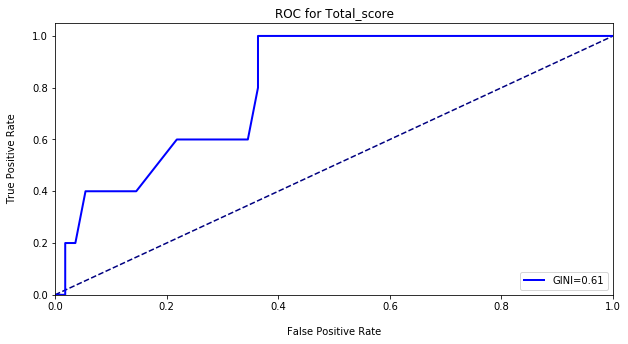

In [35]:
var_name = 'Total_score'
TPR, FPR, GINI = ROC1(roc_for_score, var_name, max_tresholds)
fig = plt.figure(1, [10, 5])        
plt.xlabel('False Positive Rate', fontdict=None, labelpad=15)
plt.ylabel('True Positive Rate', fontdict=None, labelpad=15)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC for '+var_name)
plt.plot(FPR, TPR, color='blue', lw=2, label='GINI=%0.2f'% GINI)
plt.legend(loc="lower right")
my_file = Path(my_path+'\\output_4\\ROC_{0}.png'.format(var_name))
if my_file.is_file() == False:
    plt.savefig(my_path + '\\output_4\\ROC_{0}.png'.format(var_name))
plt.show()

In [36]:
scores_for_vars_w.to_csv(my_path + '\\output_4\\scores_of_borrowers_vars_and_total.csv',
                                      header=True)
IV_table.to_csv(my_path + '\\output_4\\vars_power_of_prediction.csv',
                                      header=True)

In [20]:
print("""part_4 выполнена, показаны IV по всем переменным, присвоены веса переменным, найден общий скоринг каждого заёмщика, построена ROC-кривая, 
посмотрите на результаты в папке output_4""")

part_4 выполнена, показаны IV по всем переменным, присвоены веса переменным, найден общий скоринг каждого заёмщика, построена ROC-кривая, 
посмотрите на результаты в папке output_4
